In [1]:
import gc
from desom.som_layer import SOMLayer
from desom.autoencoder import conv2d_autoencoder
from desom.datasets import load_data

import tensorflow as tf
from keras.models import Model, Sequential
from keras.metrics import Mean, MeanAbsoluteError
from keras.backend import set_session, clear_session, get_session

import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
import xarray as xr
import multiprocessing

%load_ext autoreload
%autoreload 2

physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

2023-06-16 15:16:36.076607: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-16 15:16:38.991877: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [15]:
map_size = (8, 8)
latent_dim = 32
input_shape = X_s.shape[1:]
save_dir = 'results/tmp'
epochs = 5
batch_size = 32
save_file_ae = Path(f'{save_dir}/ae_weights-epoch{epochs}.h5')
if not save_file_ae.is_file():
    def do_fit(X_s, epochs, batch_size, verbose):
        autoencoder, _, _ = conv2d_autoencoder(input_shape, latent_dim, [32, 32, 64, 64], 5, 2, 'stretch', meanX, varX)
        autoencoder.compile('adam', 'mse')
        autoencoder.fit(X_s, X_s, epochs=epochs, batch_size=batch_size, verbose=verbose)
        autoencoder.save_weights(save_file_ae)
    process_eval = multiprocessing.Process(target=do_fit, args=(X_s, epochs, batch_size, 1))
    process_eval.start()
    process_eval.join()

1/1 [==============================] - 0s 194ms/step


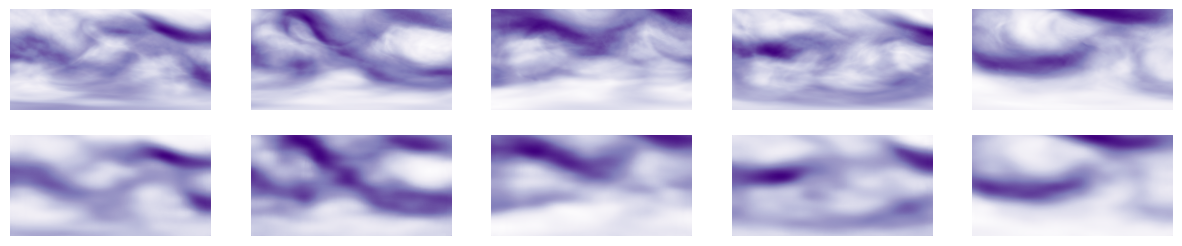

In [16]:
indices = np.random.randint(len(X_s), size=5)
theseX = X_s[indices]

autoencoder, encoder, decoder = conv2d_autoencoder(input_shape, latent_dim, [32, 32, 64, 64], 5, 2, 'stretch', meanX, varX)
autoencoder.load_weights(save_file_ae)
theseXp = autoencoder.predict(theseX)
fig, axes = plt.subplots(2, 5, figsize=(15, 3))
for x, xp, axs in zip(theseX, theseXp, axes.T):
    axs[0].imshow(x, cmap='Purples')
    axs[1].imshow(xp, cmap='Purples')
    for ax in axs:
        ax.axis('off')

1/1 [==============================] - 0s 29ms/step


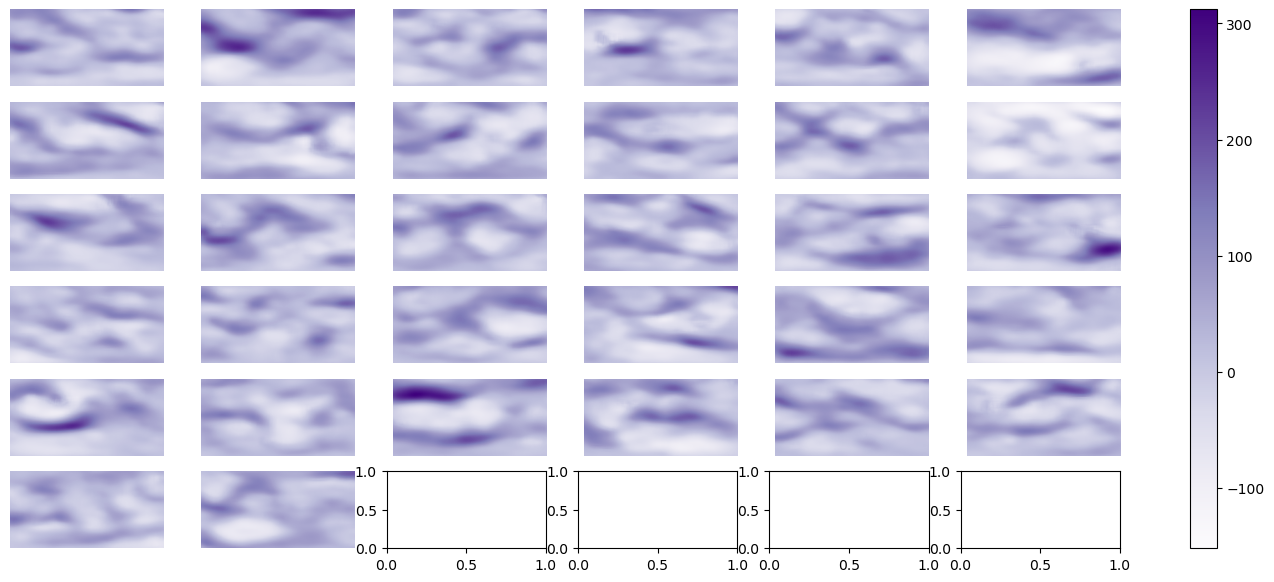

In [9]:
images = decoder.predict(np.eye(latent_dim)[:, :, None])
vmin, vmax = np.amin(images), np.amax(images)
fig, axes = plt.subplots(6, latent_dim // 5, figsize=(18, 7))
for im, ax in zip(images, axes.flatten()):
    hehe = ax.imshow(im.reshape(X_s.shape[1:3]), cmap='Purples', vmin=vmin, vmax=vmax)
    ax.axis('off')
plt.colorbar(hehe, ax=axes)

In [6]:
som_layer = SOMLayer(map_size, name='som', loss_factor=10)(encoder.output)
model = Model(
    inputs=autoencoder.input, outputs=[autoencoder.output, som_layer]
)
model.compile(
    loss={'denormalize_output': "mse", "som": 'mse'},
    loss_weights=[1, 0.],
    optimizer='adam',
)

In [7]:
epochs = 5
batch_size = 16
for layer in model.layers:
    layer.trainable = layer.name == 'som'
save_file = Path(f'{save_dir}/desom_weights-epoch{epochs}.h5')
Y_s = np.zeros(len(X_s))
model.fit(X_s, [X_s, Y_s], epochs=epochs, batch_size=batch_size, verbose=1)
model.save_weights(save_file)


Epoch 1/5


2023-06-16 15:17:51.366797: W tensorflow/tsl/framework/bfc_allocator.cc:366] Garbage collection: deallocate free memory regions (i.e., allocations) so that we can re-allocate a larger region to avoid OOM due to memory fragmentation. If you see this message frequently, you are running near the threshold of the available device memory and re-allocation may incur great performance overhead. You may try smaller batch sizes to observe the performance impact. Set TF_ENABLE_GPU_GARBAGE_COLLECTION=false if you'd like to disable this feature.
2023-06-16 15:17:51.564946: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x7f65b1db6550 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-06-16 15:17:51.564991: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA GeForce GTX 1080 Ti, Compute Capability 6.1
2023-06-16 15:17:51.572087: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR

1439/1439 [==============================] - 70s 43ms/step - loss: 7.1853 - denormalize_output_loss: 5.3878 - som_loss: 0.2327
Epoch 2/5
1439/1439 [==============================] - 61s 43ms/step - loss: 4.6888 - denormalize_output_loss: 4.4297 - som_loss: 0.0685
Epoch 3/5
1439/1439 [==============================] - 61s 42ms/step - loss: 4.3622 - denormalize_output_loss: 4.1333 - som_loss: 0.0533
Epoch 4/5
1439/1439 [==============================] - 61s 42ms/step - loss: 4.0836 - denormalize_output_loss: 3.8656 - som_loss: 0.0363
Epoch 5/5
1439/1439 [==============================] - 61s 42ms/step - loss: 3.8365 - denormalize_output_loss: 3.6247 - som_loss: 4.7253e-04


In [12]:
for l in model.layers:
    print(l.name, l.trainable)

input False
resize_input False
normalize_input False
encoder_conv_0 False
encoder_maxpool_0 False
encoder_conv_1 False
encoder_maxpool_1 False
encoder_conv_2 False
encoder_maxpool_2 False
encoder_conv_3 False
encoder_maxpool_3 False
flatten False
dense1 False
dense2 False
reshape False
decoder_conv_3 False
decoder_upsample_3 False
decoder_conv_2 False
decoder_upsample_2 False
decoder_conv_1 False
decoder_upsample_1 False
decoder_conv_0 False
decoder_upsample_0 False
decoder_0 False
resize_output False
denormalize_output False
som True


2/2 [==============================] - 0s 16ms/step


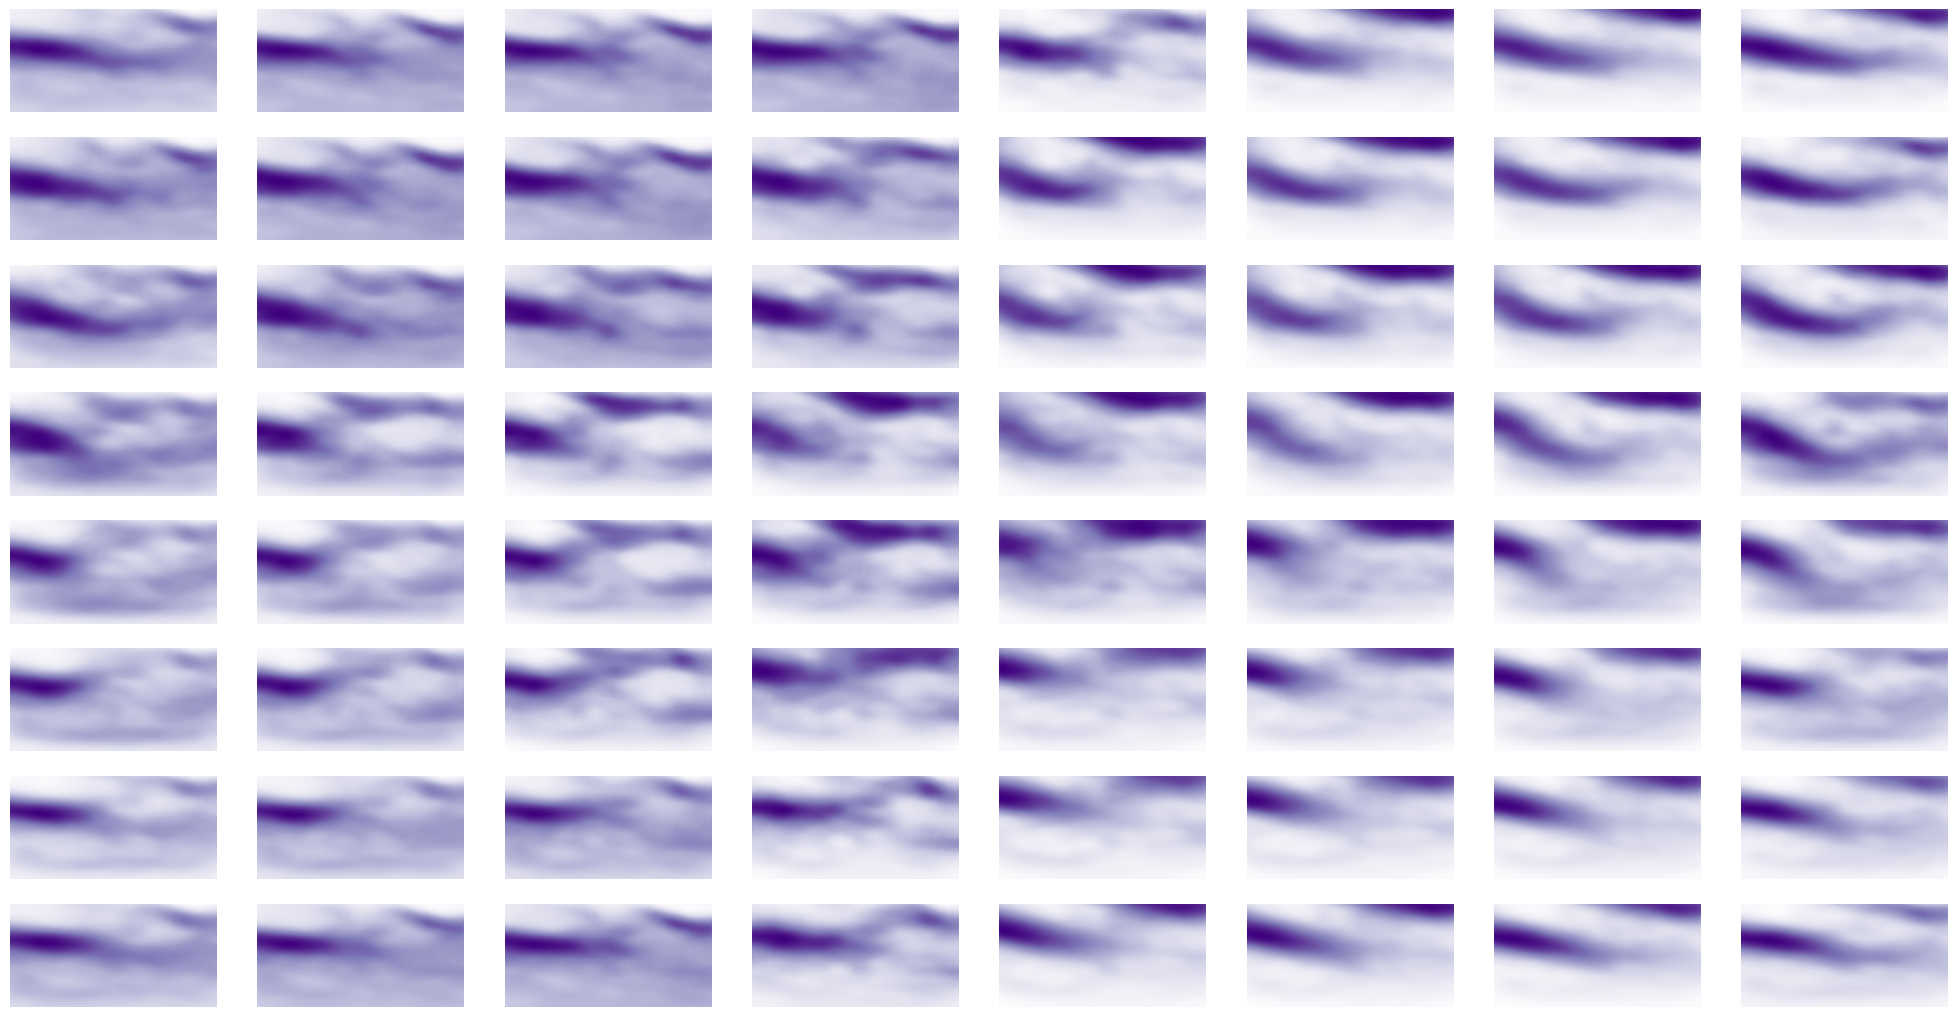

In [8]:
images = decoder.predict(model.get_layer(name='som').get_weights()[0][:, :, None])
fig, axes = plt.subplots(*map_size, figsize=(25, 13))
for im, ax in zip(images, axes.flatten(order='F')):
    ax.imshow(im, cmap='Purples')
    ax.axis('off')

In [ ]:
from keras.layers import Lambda
argmax_layer = Lambda(lambda x: tf.argmin(x, axis=1), name='y_pred')(som_layer)
classifier = Model(inputs=encoder.input, outputs=argmax_layer)
classifier.predict(X[0:100])

In [ ]:
from keras.layers import Input
def zeroloss(ypred, ytrue):
    return 0.
(X, Y), (X_val, Y_val) = load_data('mnist', flatten=True)
map_size = (8, 8)

x = Input(shape=(X.shape[1],), name='input')
som = SOMLayer(map_size, name='som')(x)
onlysom = Model(inputs=x, outputs=som)
onlysom.compile(optimizer='adam')
onlysom.fit(X, batch_size=256, epochs=5)

In [ ]:
images = onlysom.get_layer(name='som').get_weights()[0]
fig, axes = plt.subplots(*map_size, figsize=(15, 15))
for im, ax in zip(images, axes.flatten(order='F')):
    ax.imshow(im.reshape((28, 28)), cmap='gray')
    ax.axis('off')